# Gestión de Riesgos Financieros

## Librerías

In [146]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
from scipy.stats import chi2

## 1. Elección de los Activos

Se lista un conjunto de activos que sean candidatos para armar el portafolio:


- Renta variable USA: ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ', 'TSLA','UNH', 'RGC', 'QUBT', 'DFDV', 'QBTS', 'RGTI', 'MNPR', 'DGNX', 'TGEN', 'NNNN',...]

- Renta fija: ['TLT' (bonos largos), 'IEF' (bonos 7–10Y), 'SHY' (bonos cortos)]

- Commodities y refugios: ['GLD' (oro), 'SLV' (plata), 'DBC' (mixto)]

- Internacional/mercados emergentes: ['VEA' (desarrollados), 'VWO' (emergentes)]

- Alternativos o defensivos: ['XLU' (utilities), 'XLP' (consumo básico)]

- Mercado FX: ['USD/EUR', 'USD/JPY', 'USD/PEN']


Se define un Benchmark con el cual comparar el portafolio

- Benchmark: ['SPY']

In [147]:
Acciones = ['AAPL', 'ABBV', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADP', 'AFL', 'ALL', 'AMAT', 'AMGN', 'AMD', 'AMZN', 'ANET', 'APO', 'APP', 'ATLN', 'AVGO', 'AXP', 'BA', 'BAC', 'BAP', 'BK', 'BKNG', 'BLK', 'BMY',
            'BRK-B', 'BSX', 'C', 'CB', 'CAT', 'CEG', 'CHTR', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DGNX', 'DHI', 'DHR', 'DE', 'DELL', 'DIS', 'DFDV', 'DUK', 'ELV', 'EME', 'EOG', 'EPD',
            'ET', 'F', 'FI', 'GE', 'GEV', 'GILD','GOOG', 'GM', 'GS', 'HCA', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'IFS', 'ISRG', 'IOBT', 'JNJ', 'JPM', 'KKR', 'KLAC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'LRCX',
            'MA', 'MCD', 'MDLZ', 'MDT', 'MET','META', 'MNPR', 'MMC', 'MO', 'MPLX', 'MRK', 'MS', 'MSFT', 'MTNB', 'MU', 'NEE', 'NFLX', 'NKE', 'NNNN', 'NOW', 'NSRGY', 'NVDA', 'ORCL', 'PANW', 'PEP', 'PFE', 'PG',
            'PGEN', 'PGR', 'PLD','PLTR', 'PM', 'PNC', 'PPSI', 'PWR', 'QCOM', 'QBTS', 'QUBT', 'RGC', 'REGN', 'RGTI', 'RTX', 'SAP', 'SBUX', 'SCHW', 'SLB', 'SO', 'SPGI', 'SYK', 'T', 'TGEN', 'TMO', 'TM', 'TJX',
            'TMUS', 'TRV', 'TSLA', 'TXN', 'UBER', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VRTX', 'VZ', 'WFC', 'WMT', 'XOM']

Bonos = ['TLT', 'IEF', 'SHY']

Commodities = ['GLD', 'SLV', 'DBC']

Emergentes = ['VEA', 'VWO']

Defensivos = ['XLU', 'XLP']

FX = ['USD/EUR', 'USD/JPY', 'USD/PEN']

Benchmark = ['SPY']

### Análisis Fundamental de las Acciones

In [148]:
def obtener_datos_fundamentales(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info

    return {
        'Ticker': ticker,
        'Nombre': info.get('shortName'),
        'Sector': info.get('sector'),
        'Industria': info.get('industry'),
        'Capitalización Bursátil': info.get('marketCap'),
        'PER': info.get('trailingPE'),
        'Forward PER': info.get('forwardPE'),
        'P/E': info.get('trailingPE'),
        'P/B': info.get('priceToBook'),
        'ROE': info.get('returnOnEquity'),
        'ROA': info.get('returnOnAssets'),
        'Deuda/Patrimonio': info.get('debtToEquity'),
        'Crec. Ingresos (%)': info.get('revenueGrowth'),
        'Crec. Utilidad (%)': info.get('earningsGrowth'),
        'Dividend Yield': info.get('dividendYield'),
        'Beta': info.get('beta')
    }

datos_fundamentales = [obtener_datos_fundamentales(tk) for tk in Acciones]
df_fundamental = pd.DataFrame(datos_fundamentales)
df_fundamental

,Ticker,Nombre,Sector,Industria,Capitalización Bursátil,PER,Forward PER,P/E,P/B,ROE,ROA,Deuda/Patrimonio,Crec. Ingresos (%),Crec. Utilidad (%),Dividend Yield,Beta
0,AAPL,Apple Inc.,Technology,Consumer Electronics,3436888195072,35.089394,27.868832,35.089394,52.265850,1.49814,0.24546,154.486,0.096,0.121,0.45,1.165
1,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,365130285056,97.957350,17.039572,97.957350,-1987.403800,1.12854,0.08869,NaN,0.066,-0.324,3.17,0.503
2,ABT,Abbott Laboratories,Healthcare,Medical Devices,229305614336,16.530740,25.532946,16.530740,4.534816,0.30931,0.06617,26.501,0.074,0.365,1.79,0.705
3,ACGL,Arch Capital Group Ltd.,Financial Services,Insurance - Diversified,33858519040,9.381593,10.035398,9.381593,1.527067,0.17087,0.03793,11.840,0.233,-0.021,NaN,0.475
4,ACN,Accenture plc,Technology,Information Technology Services,153850920960,19.650755,17.555792,19.650755,5.034342,0.26928,0.11245,25.881,0.077,0.147,2.40,1.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,VRTX,Vertex Pharmaceuticals Incorpor,Healthcare,Biotechnology,100707827712,27.936699,20.926477,27.936699,5.861225,0.22771,0.13094,8.893,0.121,NaN,NaN,0.444
147,VZ,Verizon Communications Inc.,Communication Services,Telecom Services,186530004992,10.288372,9.353065,10.288372,1.809851,0.18454,0.05204,167.439,0.052,0.083,6.13,0.362
148,WFC,Wells Fargo & Company,Financial Services,Banks - Diversified,246985228288,13.247422,14.043716,13.247422,1.509338,0.11498,0.01059,NaN,0.019,0.203,2.33,1.196
149,WMT,Walmart Inc.,Consumer Defensive,Discount Stores,798042030080,42.735043,36.764706,42.735043,9.531072,0.21783,0.07151,75.780,0.025,-0.111,0.94,0.664


In [149]:
# Se realiza un filtrado de las acciones
# Aplicamos los filtros
df_filtradas = df_fundamental.copy()

filtros = (
    (df_filtradas['PER'] < 50) &
    (df_filtradas['Forward PER'] < df_filtradas['PER']) &
    (df_filtradas['ROE'] > 0.10) &
    (df_filtradas['ROA'] > 0.02) &
    (df_filtradas['Deuda/Patrimonio'] < 150) &
    (df_filtradas['Crec. Ingresos (%)'] > 0) &
    (df_filtradas['Crec. Utilidad (%)'] > 0) &
    (df_filtradas['Dividend Yield'] >= 0.01) &
    (df_filtradas['Beta'] >= 0.7) & (df_filtradas['Beta'] <= 1.7)
)

# Ordenar por calidad (ROE * Crec. Ingresos)
df_filtradas['Score Calidad'] = df_filtradas['ROE'] *df_filtradas['Crec. Ingresos (%)']
df_ordenado = df_filtradas[filtros].sort_values(by='Score Calidad', ascending=False)
df_ordenado

,Ticker,Nombre,Sector,Industria,Capitalización Bursátil,PER,Forward PER,P/E,P/B,ROE,ROA,Deuda/Patrimonio,Crec. Ingresos (%),Crec. Utilidad (%),Dividend Yield,Beta,Score Calidad
75,KLAC,KLA Corporation,Technology,Semiconductor Equipment & Materials,115457957888,28.818840,26.658745,28.818840,24.616380,1.00775,0.19897,129.746,0.236,0.467,0.87,1.432,0.237829
81,LRCX,Lam Research Corporation,Technology,Semiconductor Equipment & Materials,125941841920,23.978313,23.304451,23.978313,12.802008,0.58238,0.18399,48.233,0.336,0.722,0.92,1.661,0.195680
145,V,Visa Inc.,Financial Services,Credit Services,668595585024,33.672535,27.209322,33.672535,17.590258,0.51755,0.17049,65.017,0.143,0.121,0.69,0.940,0.074010
94,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3866511802368,38.163610,34.793980,38.163610,11.258116,0.33281,0.14203,32.661,0.181,0.237,0.64,1.055,0.060239
7,ADP,"Automatic Data Processing, Inc.",Technology,Software - Application,122237935616,30.209211,27.763570,30.209211,19.766178,0.76003,0.06315,148.765,0.075,0.106,2.04,0.820,0.057002
139,TXN,Texas Instruments Incorporated,Technology,Semiconductors,176890789888,35.570385,33.090137,35.570385,10.782489,0.29991,0.10406,85.612,0.164,0.156,2.80,1.022,0.049185
96,MU,"Micron Technology, Inc.",Technology,Semiconductors,135269244928,21.778378,9.391608,21.778378,2.665211,0.13109,0.06550,31.948,0.366,4.602,0.38,1.374,0.047979
117,QCOM,QUALCOMM Incorporated,Technology,Semiconductors,170320166912,15.251207,12.906788,15.251207,6.288594,0.44615,0.14174,54.350,0.103,0.294,2.26,1.228,0.045953
89,MMC,"Marsh & McLennan Companies, Inc",Financial Services,Insurance Brokers,101869412352,24.875150,21.973490,24.875150,6.461582,0.28408,0.07864,135.265,0.121,0.079,1.74,0.775,0.034374
10,AMAT,"Applied Materials, Inc.",Technology,Semiconductor Equipment & Materials,129808064512,19.302505,16.692984,19.302505,6.618183,0.35635,0.15884,32.106,0.077,0.083,1.14,1.694,0.027439


In [150]:
# === Selección automática del TOP 3 para 'base' ===

topN = 3

cols_minimas = {'Ticker', 'Nombre', 'Sector', 'Score Calidad'}
faltantes = cols_minimas - set(df_ordenado.columns)
if faltantes:
    raise KeyError(f"Faltan columnas en df_ordenado: {faltantes}")

# Tomar los 3 primeros (ya está ordenado desc por 'Score Calidad')
top3 = (
    df_ordenado.loc[:, ['Ticker', 'Nombre', 'Sector', 'Score Calidad']]
    .dropna(subset=['Ticker'])
    .head(topN)
)

# Lista 'base' con los tickers del TOP 3
base = top3['Ticker'].astype(str).tolist()

print("Activos base seleccionados automáticamente (TOP 3 por Score):", base)
display(top3.style.format({'Score Calidad': '{:.4f}'}))

Activos base seleccionados automáticamente (TOP 3 por Score): ['KLAC', 'LRCX', 'V']


,Ticker,Nombre,Sector,Score Calidad
75,KLAC,KLA Corporation,Technology,0.2378
81,LRCX,Lam Research Corporation,Technology,0.1957
145,V,Visa Inc.,Financial Services,0.0740


### Análisis para Renta Fija

/tmp/ipython-input-1242455989.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Bonos, start='2020-01-01', interval='1d')['Close']
[*********************100%***********************]  3 of 3 completed


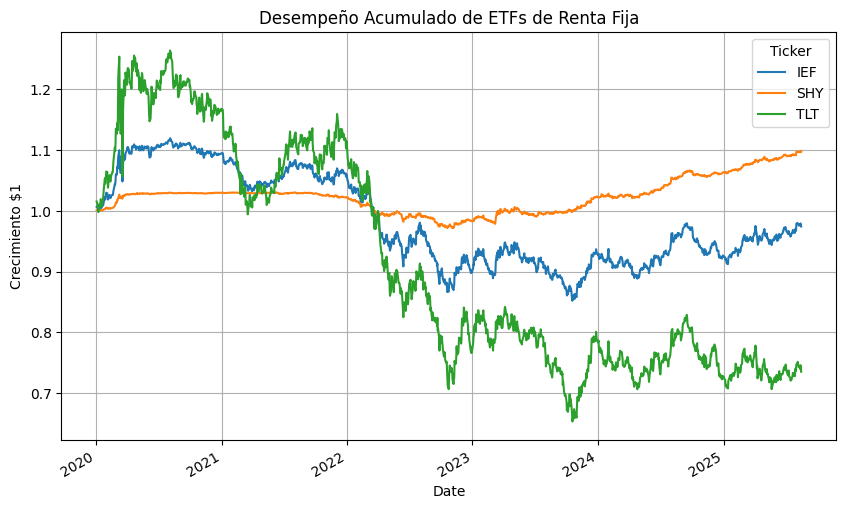

In [151]:
data = yf.download(Bonos, start='2020-01-01', interval='1d')['Close']
returns = data.pct_change().dropna()

# Gráfico de desempeño acumulado
desempeno_acum = (1 + returns).cumprod()
desempeno_acum.plot(figsize=(10,6), title='Desempeño Acumulado de ETFs de Renta Fija')
plt.ylabel('Crecimiento $1')
plt.grid(True)
plt.show()

In [152]:
# === Cuadro comparativo de renta fija (TLT, IEF, SHY) ===

def max_drawdown(cum_series: pd.Series) -> float:
    """Max Drawdown como porcentaje positivo (ej. 0.20 = -20%)."""
    peak = cum_series.cummax()
    drawdown = (cum_series / peak) - 1.0
    return -drawdown.min()

n_days = len(returns)

# Métricas por ticker
rows = []
for tk in returns.columns:
    ret_d = returns[tk].dropna()

    # Desempeño acumulado (crec. de $1)
    cum = (1 + ret_d).cumprod()
    total_return = cum.iloc[-1] - 1.0

    # Anualización usando duración real de la muestra
    ann_return = (1.0 + total_return) ** (252 / len(ret_d)) - 1.0
    ann_vol = ret_d.std(ddof=1) * np.sqrt(252)

    # Peor día y max drawdown
    worst_day = ret_d.min()
    mdd = max_drawdown(cum)  # positivo (e.g., 0.23 = -23%)

    rows.append({
        "Ticker": tk,
        "Rend. acumulado %": total_return * 100,
        "Retorno anual %": ann_return * 100,
        "Volatilidad anual %": ann_vol * 100,
        "Peor día %": worst_day * 100,
        "Max Drawdown %": mdd * 100
    })

df_bonos_cmp = pd.DataFrame(rows).set_index("Ticker")

# Ordena por retorno anual
df_bonos_cmp = df_bonos_cmp.sort_values("Retorno anual %", ascending=False)

print("Cuadro comparativo — ETFs de Renta Fija")
display(df_bonos_cmp.round(2))

# Mejor ETF según retorno anual
mejor_bono_ticker = df_bonos_cmp.index[0]
print(f"Mejor ETF (por retorno anual): {mejor_bono_ticker} — {df_bonos_cmp.iloc[0]['Retorno anual %']:.2f}%")

# Conservar el mejor ETF:
mejor_bono = [mejor_bono_ticker]

Cuadro comparativo — ETFs de Renta Fija


,Rend. acumulado %,Retorno anual %,Volatilidad anual %,Peor día %,Max Drawdown %
Ticker,,,,,
SHY,9.73,1.67,1.88,-0.51,5.71
IEF,-2.58,-0.47,7.81,-2.51,23.92
TLT,-26.52,-5.35,17.52,-6.67,48.35


Mejor ETF (por retorno anual): SHY — 1.67%


### Elección del Activo Diversificador

In [153]:
# Candidatos a evaluar como quinto activo
candidatos = ['GLD', 'SLV', 'DBC', 'VEA', 'VWO', 'XLU', 'XLP', 'EUR=X', 'JPY=X', 'PEN=X']
tickers = base + candidatos

# Descargar precios mensuales
data = yf.download(tickers, start="2020-01-01", interval="1d")['Close']
returns = data.pct_change().dropna()

# Correlación con los activos base
correlaciones = returns.corr().loc[candidatos, base]

# Volatilidad anualizada de los candidatos
volatilidad = returns[candidatos].std() * np.sqrt(252)

# Unir métricas
resumen = correlaciones.copy()
resumen['Volatilidad anual'] = volatilidad
resumen = resumen.sort_values('Volatilidad anual')

display(resumen.round(4))

/tmp/ipython-input-2540013830.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", interval="1d")['Close']
[*********************100%***********************]  13 of 13 completed
/tmp/ipython-input-2540013830.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Ticker,KLAC,LRCX,V,Volatilidad anual
Ticker,,,,
EUR=X,-0.0201,-0.0071,-0.0191,0.0762
JPY=X,-0.0293,-0.0074,-0.0100,0.0945
GLD,0.1162,0.1411,0.0523,0.1563
XLP,0.4202,0.3990,0.5996,0.1644
DBC,0.2396,0.2593,0.2456,0.1929
VEA,0.6575,0.6635,0.6969,0.1955
PEN=X,-0.0251,-0.0225,-0.0212,0.2061
VWO,0.6310,0.6334,0.5853,0.2070
XLU,0.3556,0.3376,0.5206,0.2236


In [154]:
# Calcular la correlación promedio con los activos del portafolio base
resumen['Correlación Promedio'] = resumen[base].mean(axis=1)

# Definir la fórmula de score (pondera diversificación y riesgo)
peso_corr = 0.9  # Peso de la correlación promedio
peso_vol = 1 - peso_corr   # Peso de la volatilidad

# Normalizar variables para poder combinarlas
resumen['Z_Correlación'] = (resumen['Correlación Promedio'] - resumen['Correlación Promedio'].mean()) / resumen['Correlación Promedio'].std()
resumen['Z_Volatilidad'] = (resumen['Volatilidad anual'] - resumen['Volatilidad anual'].mean()) / resumen['Volatilidad anual'].std()

# Score final
resumen['Score Total'] = peso_corr * resumen['Z_Correlación'] + peso_vol * resumen['Z_Volatilidad']

# Selección del mejor candidato
mejor_activo = resumen.sort_values('Score Total').iloc[0]

# Mostrar top 3
print("\n Top 3 activos más recomendables:")
display(resumen.sort_values('Score Total').head(3))


 Top 3 activos más recomendables:


Ticker,KLAC,LRCX,V,Volatilidad anual,Correlación Promedio,Z_Correlación,Z_Volatilidad,Score Total
Ticker,,,,,,,,
EUR=X,-0.020054,-0.007120,-0.019073,0.076219,-0.015416,-1.077344,-1.620657,-1.131675
JPY=X,-0.029342,-0.007351,-0.009986,0.094494,-0.015559,-1.077890,-1.341502,-1.104252
PEN=X,-0.025081,-0.022521,-0.021182,0.206102,-0.022928,-1.105924,0.363365,-0.958995


In [155]:
# Selección del mejor candidato
mejor_activo_row = resumen.sort_values('Score Total').iloc[0]
mejor_ticker = mejor_activo_row.name  # El índice es el ticker

# Se guarda el mejor activo diversificador:
activo_diversificador = [mejor_ticker]

### Activos Seleccionados

In [156]:
# Activos seleccionados + benchmark
activos = base + mejor_bono + activo_diversificador
benchmark = 'SPY'
tickers = activos + [benchmark]
tickers

# Horizonte de análisis
start_date = "2020-01-02"

# Precios mensuales
data = yf.download(tickers, start=start_date, interval="1d")['Close'].ffill()

/tmp/ipython-input-4199177591.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, interval="1d")['Close'].ffill()
[*********************100%***********************]  6 of 6 completed


/tmp/ipython-input-1439723770.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  px_y = data.resample("Y").last()


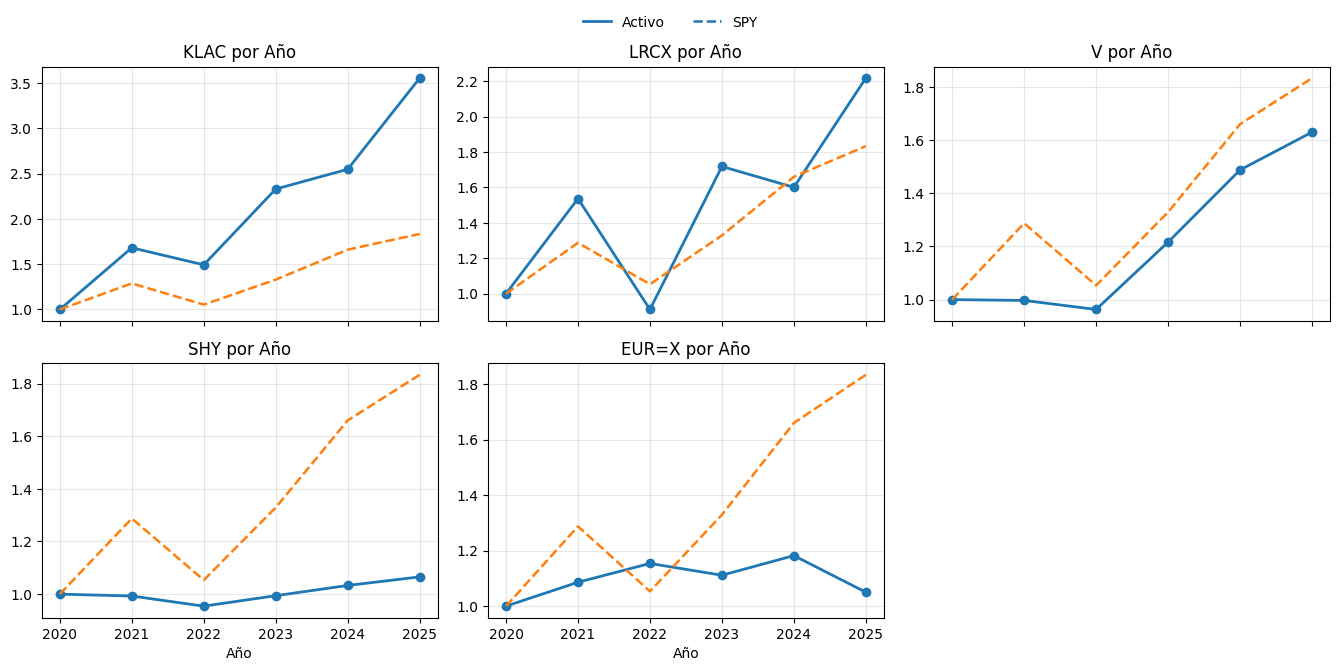

In [157]:
# Tomar el último valor de cada año calendario (close anual “a fin de año”)
px_y = data.resample("Y").last()
# Asegurar intersección de años para todos
px_y = px_y.dropna(how="all")

# Normalizar cada serie a base 1 en su primer año disponible
px_y_norm = px_y.apply(lambda s: s / s.dropna().iloc[0])

# 2) Parámetros de la grilla
n = len(activos)
ncols = 3  # ajusta a 3 o 4 según prefieras
nrows = ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols, 3.3*nrows), sharex=True)
axes = np.atleast_2d(axes)

years = px_y_norm.index.year

for i, tk in enumerate(activos):
    r = i // ncols
    c = i % ncols
    ax = axes[r, c]

    # Series del activo y benchmark alineadas por años disponibles
    s_act = px_y_norm[tk].dropna()
    s_bmk = px_y_norm[benchmark].dropna()

    # Intersección de años
    idx = s_act.index.intersection(s_bmk.index)
    s_act = s_act.loc[idx]
    s_bmk = s_bmk.loc[idx]

    # Plot
    ax.plot(s_act.index.year, s_act.values, marker='o', linewidth=2)
    ax.plot(s_bmk.index.year, s_bmk.values, linestyle='--', linewidth=1.8)

    ax.set_title(f"{tk} por Año")
    ax.grid(True, alpha=0.3)
    if r == nrows - 1:
        ax.set_xlabel("Año")
    ax.set_ylabel("")  # limpio para que el panel sea más visual

# Si sobran ejes (cuando n no llena la grilla), los ocultamos
for j in range(i + 1, nrows * ncols):
    r = j // ncols
    c = j % ncols
    axes[r, c].axis("off")

# Leyenda global (una vez)
lines_labels = [("Activo", dict(linewidth=2, linestyle='-')),
                (benchmark, dict(linewidth=1.8, linestyle='--'))]
handles = [plt.Line2D([0], [0], **style) for _, style in lines_labels]
labels = [lbl for lbl, _ in lines_labels]
fig.legend(handles, labels, loc="upper center", ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 2. Restricciones Regulatorias

- No apalancamiento ni ventas en corto:	Pesos ≥ 0
- Máx. 25% por emisor (empresa individual):	Peso máx. por activo: 0.25
- Máx. 80% en conjunto de emisores >10%:	Suma de pesos > 0.1 debe ser ≤ 0.80
- Mín. 30% en instrumentos de renta fija/garantizados:	SHY u otro instrumento conservador ≥ 0.30
- Máx. 20% en activos no tradicionales:	Activo diversificador ≤ 0.20
- Suma de pesos = 100%:	Restricción de igualdad

In [158]:
bounds = [
    (0, 0.25),  # acción 1: mínimo 0%, máximo 25%
    (0, 0.25),  # acción 2: igual
    (0, 0.25),  # acción 3: igual
    (0.30, 1.00),  # SHY: mínimo 35% por regulación SBS
    (0, 0.20)   # activo diversificador: máximo 20%
]

restricciones = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

def restric_sbs(w):
    return 0.80 - np.sum([wi for wi in w if wi > 0.10])

restricciones.append({'type': 'ineq', 'fun': restric_sbs})

## 3. Optimización del Portafolio

### Obtener datos

In [159]:
# Retornos
returns = data.pct_change().dropna()

# Subdividir retornos
ret_activos = returns[activos]
ret_benchmark = returns[benchmark]

# Métricas básicas
mean_returns = ret_activos.mean() * 252
cov_matrix = ret_activos.cov() * 252

In [160]:
# Fechas automáticas: de hoy hacia 1 año atrás
end = datetime.today()
start = end - timedelta(days=365)

# Descargar la tasa del Treasury a 5 años (GS5) desde FRED
rf = pdr.DataReader('GS5', 'fred', start, end).mean().values[0] / 100  # Convertido a proporción

print(f"Tasa libre de riesgo promedio (GS5) en el último año: {rf:.4%}")

Tasa libre de riesgo promedio (GS5) en el último año: 4.0436%


### Funciones Objetivos

In [161]:
# Ratio de Sharpe
def neg_sharpe(w, mean_returns, cov_matrix, rf):
    port_return = np.dot(w, mean_returns)
    port_vol = np.sqrt(w.T @ cov_matrix @ w)
    return -(port_return - rf) / port_vol

# Mínima Varianza
def varianza(w, cov_matrix):
    return w.T @ cov_matrix @ w

# Ratio Sortino
def neg_sortino(w, ret_activos, rf):
    # Retornos diarios del portafolio
    rp = (ret_activos @ w)
    mean_a = rp.mean() * 252
    downside = rp[rp < 0].std(ddof=1) * np.sqrt(252)
    # Evitar división por cero
    if downside == 0 or np.isnan(downside):
        return np.inf
    return -(mean_a - rf) / downside

# Valor Inicial

w0 = np.array([0.2]*5)

### Optimizar los modelos

In [162]:
# Sharpe
res_sharpe = minimize(neg_sharpe, w0, args=(mean_returns, cov_matrix, rf), method='SLSQP', bounds=bounds, constraints=restricciones)

# Mínima Varianza
res_var = minimize(varianza, w0, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=restricciones)

# Sortino
res_sortino = minimize(neg_sortino, w0, args=(ret_activos, rf), method='SLSQP', bounds=bounds, constraints=restricciones)

### Consolidar y Comparar Portafolios

In [163]:
# Inicializa DataFrame vacío
resultados = pd.DataFrame(columns=['Modelo', 'Return', 'Volatility', 'Sharpe'])

# Construir tabla resumen
def port_stats(w):
    r = np.dot(w, mean_returns)
    v = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    s = (r - rf) / v
    return [r, v, s]

# Agrega cada portafolio
nombres = ['Sharpe', 'Mínima Varianza', 'Sortino']
for nombre, res in zip(nombres, [res_sharpe, res_var, res_sortino]):
    stats = port_stats(res.x)  # Tomamos Return, Volatility, Sharpe
    resultados.loc[len(resultados)] = [nombre] + stats

# Agrega el benchmark SPY
spy_ret = ret_benchmark.mean() * 252
spy_vol = ret_benchmark.std() * np.sqrt(252)
spy_sharpe = (spy_ret - rf) / spy_vol

resultados.loc[len(resultados)] = ['SPY (Benchmark)', spy_ret, spy_vol, spy_sharpe]

resultados

,Modelo,Return,Volatility,Sharpe
0,Sharpe,0.138789,0.159654,0.616037
1,Mínima Varianza,0.046159,0.050596,0.113101
2,Sortino,0.148104,0.170943,0.629845
3,SPY (Benchmark),0.153412,0.208483,0.541892


### Gráfica Comparativa

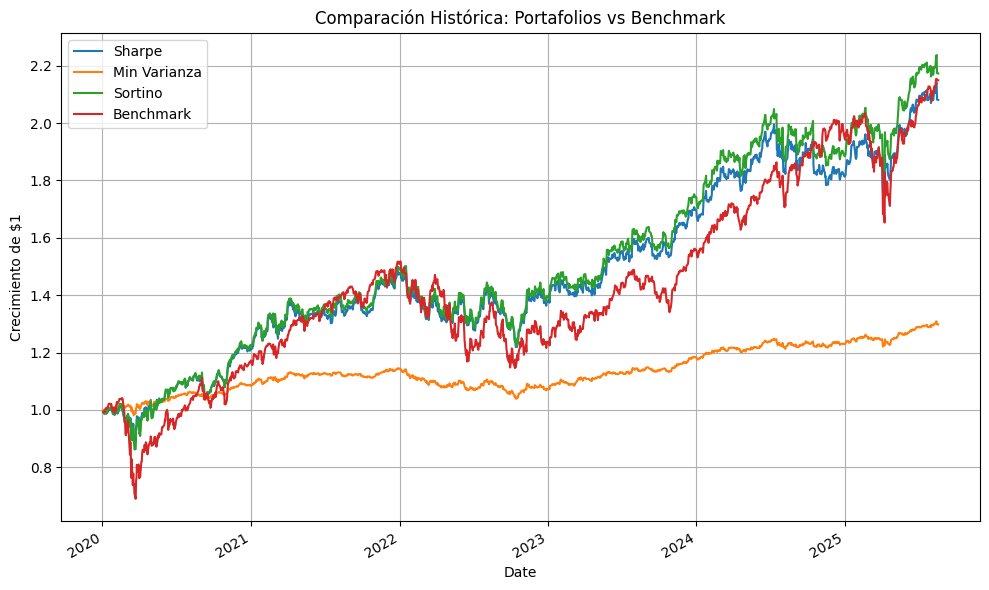

In [164]:
# Diccionario con portafolios optimizados
portafolios = {
    'Sharpe': res_sharpe.x,
    'Min Varianza': res_var.x,
    'Sortino': res_sortino.x
}

# Calcular precios acumulados de cada portafolio
precios_portafolios = {}

for nombre, pesos in portafolios.items():
    ret_port = ret_activos @ pesos
    precios_portafolios[nombre] = (1 + ret_port).cumprod()

# Agregar benchmark
precios_portafolios['Benchmark'] = (1 + ret_benchmark).cumprod()

# Unir en un DataFrame para graficar
df_comp = pd.DataFrame(precios_portafolios)

# Gráfico comparativo
df_comp.plot(figsize=(10, 6), title='Comparación Histórica: Portafolios vs Benchmark')
plt.ylabel('Crecimiento de $1')
plt.grid(True)
plt.tight_layout()
plt.show()

### Frontera Eficiente

Portafolios válidos generados: 6757


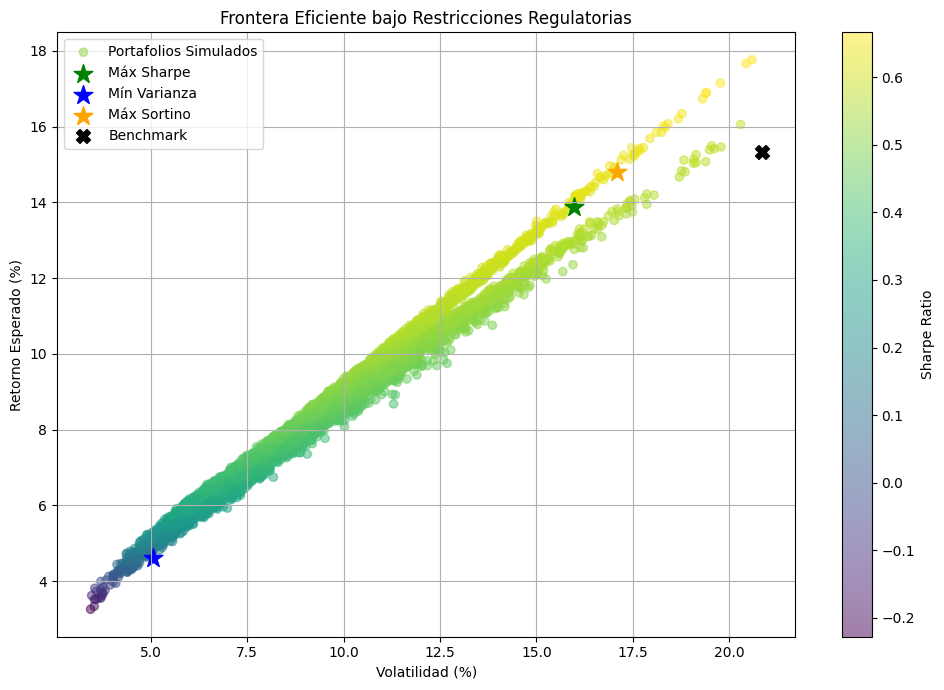

In [165]:
n_portfolios = 100000
results = []
weights_record = []

np.random.seed(42)
count_valid = 0

for _ in range(n_portfolios):
    # Rango de pesos por activo según SBS:
    w1 = np.random.uniform(0, 0.25)   # acción 1
    w2 = np.random.uniform(0, 0.25)   # acción 2
    w3 = np.random.uniform(0, 0.25)   # acción 3
    w4 = np.random.uniform(0.30, 1.00)  # Bono
    w5 = np.random.uniform(0, 0.20)   # diversificador

    w = np.array([w1, w2, w3, w4, w5])
    w = w / np.sum(w)  # normalizar para que suma total = 1

    # Verificar restricción SBS adicional (máx. 80% en activos >10%)
    if np.sum([wi for wi in w if wi > 0.10]) <= 0.80:
        r = np.dot(w, mean_returns) * 100
        v = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * 100
        s = (r / 100 - rf) / (v / 100)

        results.append((r, v, s))
        weights_record.append(w)
        count_valid += 1

print(f"Portafolios válidos generados: {count_valid}")

# Convertir a arrays
results = np.array(results)
returns_sim = results[:, 0]
vol_sim = results[:, 1]
sharpe_sim = results[:, 2]

# Extraer los portafolios optimizados ya calculados
w_sharpe = res_sharpe.x
w_var = res_var.x
w_sortino = res_sortino.x

def get_stats(w):
    r = np.dot(w, mean_returns) * 100
    v = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * 100
    return r, v

r_sharpe, v_sharpe = get_stats(w_sharpe)
r_var, v_var = get_stats(w_var)
r_sortino, v_sortino = get_stats(w_sortino)

# SPY
r_spy = spy_ret * 100
v_spy = spy_vol * 100

# Plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(vol_sim, returns_sim, c=sharpe_sim, cmap='viridis', alpha=0.5, label='Portafolios Simulados')
plt.colorbar(sc, label='Sharpe Ratio')

# Marcar portafolios óptimos y benchmark
plt.scatter(v_sharpe, r_sharpe, color='green', marker='*', s=200, label='Máx Sharpe')
plt.scatter(v_var, r_var, color='blue', marker='*', s=200, label='Mín Varianza')
plt.scatter(v_sortino, r_sortino, color='orange', marker='*', s=200, label='Máx Sortino')
plt.scatter(v_spy, r_spy, color='black', marker='X', s=100, label='Benchmark')

plt.title('Frontera Eficiente bajo Restricciones Regulatorias')
plt.xlabel('Volatilidad (%)')
plt.ylabel('Retorno Esperado (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Cálculo de las Métricas de Riesgo

### Parámetros Generales

In [166]:
confianza = 0.95
z = norm.ppf(1 - confianza)
horizonte = 10  # días
monto_invertido = 100000  # USD
n_simulaciones = 100000 # Para Monte Carlo
lambda_=0.94 # Para EWMA

### VaR Delta-Normal

In [167]:
# Función para calcular VaR Delta-Normal
def calcular_var_delta_normal(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):

    # Volatilidad diaria por activo
    vol_individual = retornos.std()

    # VaR individual porcentual
    var_ind_pct = -z * vol_individual * np.array(w) * np.sqrt(horizonte)

    # VaR individual absoluto en USD
    var_ind_usd = var_ind_pct * monto_invertido

    # VaR de portafolio total
    cov = retornos.cov()
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w)))
    var_port_pct = -z * port_vol * np.sqrt(horizonte)
    var_port_usd = var_port_pct * monto_invertido

    return var_ind_pct, var_ind_usd, var_port_pct, var_port_usd

# Diccionarios para almacenar resultados
var_pct_dict = {}
var_usd_dict = {}
var_portafolio_pct = {}
var_portafolio_usd = {}

# Calcular VaR para cada portafolio
for nombre, pesos in portafolios.items():
    v_pct_ind, v_usd_ind, v_pct_port, v_usd_port = calcular_var_delta_normal(
        pesos, ret_activos)

    var_pct_dict[nombre] = v_pct_ind * 100  # a porcentaje
    var_usd_dict[nombre] = v_usd_ind
    var_portafolio_pct[nombre] = [v_pct_port * 100]
    var_portafolio_usd[nombre] = [v_usd_port]

# DataFrames finales

# En porcentaje (% del monto invertido)
df_var_individual_pct = pd.DataFrame(var_pct_dict, index=activos)
df_var_portafolio_pct = pd.DataFrame(var_portafolio_pct, index=['VaR Portafolio %'])

# En dólares (USD)
df_var_individual_usd = pd.DataFrame(var_usd_dict, index=activos)
df_var_portafolio_usd = pd.DataFrame(var_portafolio_usd, index=['VaR Portafolio USD'])

# Mostrar resultados
print("VaR Individual (%)")
display(df_var_individual_pct)

print("VaR del Portafolio (%)")
display(df_var_portafolio_pct)

print("VaR Individual (USD)")
display(df_var_individual_usd)

print("VaR del Portafolio (USD)")
display(df_var_portafolio_usd)

VaR Individual (%)


,Sharpe,Min Varianza,Sortino
KLAC,3.722461,5.139760e-16,3.722461
LRCX,1.573794,1.574370e+00,1.572009
V,0.057106,1.337790e-02,0.701170
SHY,0.329269,4.845817e-01,0.285313
EUR=X,0.249742,2.459720e-01,0.249742


VaR del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Portafolio %,5.231266,1.657854,5.60118


VaR Individual (USD)


,Sharpe,Min Varianza,Sortino
KLAC,3722.461393,5.139760e-13,3722.461299
LRCX,1573.793700,1.574370e+03,1572.008760
V,57.105905,1.337790e+01,701.169559
SHY,329.268783,4.845817e+02,285.313362
EUR=X,249.741951,2.459720e+02,249.742038


VaR del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Portafolio USD,5231.266129,1657.853568,5601.180052


### VaR Histórico

In [168]:
def calcular_var_historico(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    # Portafolio: pasamos a log-retornos para agregar en el tiempo
    ret_port = retornos @ w
    log_port = np.log1p(ret_port)
    log_T = log_port.rolling(horizonte).sum().dropna()
    ret_T = np.expm1(log_T)  # retorno compuesto a T días

    var_port_pct = -np.percentile(ret_T, (1 - nivel) * 100.0)
    var_port_usd = var_port_pct * monto_invertido

    # VaR "individual ponderado" a T días (mismo criterio que el resto del script)
    var_ind_pct, var_ind_usd = [], []
    for i, col in enumerate(retornos.columns):
        log_i = np.log1p(retornos[col]).rolling(horizonte).sum().dropna()
        ret_i_T = np.expm1(log_i)
        var_i_pct = -np.percentile(ret_i_T, (1 - nivel) * 100.0)
        var_ind_pct.append(var_i_pct * w[i])
        var_ind_usd.append(var_i_pct * w[i] * monto_invertido)

    return np.array(var_ind_pct) * 100.0, np.array(var_ind_usd), var_port_pct * 100.0, var_port_usd

# Diccionarios de resultados
var_hist_pct_dict = {}
var_hist_usd_dict = {}
var_hist_portafolio_pct = {}
var_hist_portafolio_usd = {}

for nombre, pesos in portafolios.items():
    v_pct_ind, v_usd_ind, v_pct_port, v_usd_port = calcular_var_historico(
        pesos, ret_activos)

    var_hist_pct_dict[nombre] = v_pct_ind
    var_hist_usd_dict[nombre] = v_usd_ind
    var_hist_portafolio_pct[nombre] = [v_pct_port]
    var_hist_portafolio_usd[nombre] = [v_usd_port]

# En porcentaje
df_var_hist_ind_pct = pd.DataFrame(var_hist_pct_dict, index=activos)
df_var_hist_port_pct = pd.DataFrame(var_hist_portafolio_pct, index=['VaR Portafolio %'])

# En USD
df_var_hist_ind_usd = pd.DataFrame(var_hist_usd_dict, index=activos)
df_var_hist_port_usd = pd.DataFrame(var_hist_portafolio_usd, index=['VaR Portafolio USD'])

# Mostrar
print("VaR Histórico Individual (%)")
display(df_var_hist_ind_pct)

print("VaR Histórico del Portafolio (%)")
display(df_var_hist_port_pct)

print("VaR Histórico Individual (USD)")
display(df_var_hist_ind_usd)

print("VaR Histórico del Portafolio (USD)")
display(df_var_hist_port_usd)

VaR Histórico Individual (%)


,Sharpe,Min Varianza,Sortino
KLAC,2.731091,3.770933e-16,2.731091
LRCX,1.258582,1.259043e+00,1.257154
V,0.047119,1.103842e-02,0.578551
SHY,0.270576,3.982037e-01,0.234455
EUR=X,0.240541,2.369099e-01,0.240541


VaR Histórico del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Portafolio %,3.982362,1.235557,4.263389


VaR Histórico Individual (USD)


,Sharpe,Min Varianza,Sortino
KLAC,2731.090844,3.770933e-13,2731.090774
LRCX,1258.581702,1.259043e+03,1257.154263
V,47.119408,1.103842e+01,578.551277
SHY,270.575670,3.982037e+02,234.455430
EUR=X,240.540961,2.369099e+02,240.541045


VaR Histórico del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Portafolio USD,3982.361508,1235.557098,4263.38852


### VaR Monte Carlo

In [169]:
def calcular_var_monte_carlo(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    # 1) Estadísticas en log-retornos diarios
    logrets = np.log1p(retornos)
    mu = logrets.mean().values              # vector mu_diario (log)
    sigma = logrets.std(ddof=1).values      # vector sigma_diario (log)
    corr = np.corrcoef(logrets.T)           # correlación entre activos (log)
    n_activos = len(w)

    # 2) Cholesky de correlación para choques correlacionados
    L = np.linalg.cholesky(corr)

    # 3) Simular shocks Z ~ N(0, I) y correlacionarlos
    Z = np.random.randn(n_simulaciones, n_activos) @ L.T   # (n_sim, n_activos)

    # 4) Escalar a horizonte T: log-retorno GBM de cada activo
    T = float(horizonte)   # días
    drift = (mu - 0.5 * sigma**2) * T
    vol_T = sigma * np.sqrt(T)
    logR = drift + Z * vol_T          # log(S_T/S_0)
    R = np.exp(logR) - 1.0            # retorno compuesto a T

    # 5) Retorno del portafolio a T (pesos fijos, aprox. lineal en retornos)
    port_ret_sim = R @ w

    # 6) VaR de portafolio
    var_port_pct = -np.percentile(port_ret_sim, (1 - nivel) * 100.0)
    var_port_usd = var_port_pct * monto_invertido

    # 7) VaR "individual ponderado" (misma lógica que tu código actual)
    var_ind_pct = []
    var_ind_usd = []
    for i in range(n_activos):
        var_i_pct = -np.percentile(R[:, i], (1 - nivel) * 100.0)
        var_ind_pct.append(var_i_pct * w[i])
        var_ind_usd.append(var_i_pct * w[i] * monto_invertido)

    return np.array(var_ind_pct) * 100.0, np.array(var_ind_usd), var_port_pct * 100.0, var_port_usd

  # Diccionarios de resultados
var_mc_pct_dict = {}
var_mc_usd_dict = {}
var_mc_portafolio_pct = {}
var_mc_portafolio_usd = {}

for nombre, pesos in portafolios.items():
    v_pct_ind, v_usd_ind, v_pct_port, v_usd_port = calcular_var_monte_carlo(
        pesos, ret_activos)

    var_mc_pct_dict[nombre] = v_pct_ind
    var_mc_usd_dict[nombre] = v_usd_ind
    var_mc_portafolio_pct[nombre] = [v_pct_port]
    var_mc_portafolio_usd[nombre] = [v_usd_port]

# En porcentaje
df_var_mc_ind_pct = pd.DataFrame(var_mc_pct_dict, index=activos)
df_var_mc_port_pct = pd.DataFrame(var_mc_portafolio_pct, index=['VaR Portafolio %'])

# En USD
df_var_mc_ind_usd = pd.DataFrame(var_mc_usd_dict, index=activos)
df_var_mc_port_usd = pd.DataFrame(var_mc_portafolio_usd, index=['VaR Portafolio USD'])

# Mostrar
print("VaR Monte Carlo Individual (%)")
display(df_var_mc_ind_pct)

print("VaR Monte Carlo del Portafolio (%)")
display(df_var_mc_port_pct)

print("VaR Monte Carlo Individual (USD)")
display(df_var_mc_ind_usd)

print("VaR Monte Carlo del Portafolio (USD)")
display(df_var_mc_port_usd)

VaR Monte Carlo Individual (%)


,Sharpe,Min Varianza,Sortino
KLAC,3.292357,4.571690e-16,3.301797
LRCX,1.421872,1.428330e+00,1.424647
V,0.052989,1.252310e-02,0.647863
SHY,0.295951,4.375475e-01,0.253373
EUR=X,0.250976,2.478706e-01,0.252187


VaR Monte Carlo del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Portafolio %,4.621418,1.475371,4.986976


VaR Monte Carlo Individual (USD)


,Sharpe,Min Varianza,Sortino
KLAC,3292.357328,4.571690e-13,3301.796909
LRCX,1421.872130,1.428330e+03,1424.647178
V,52.989091,1.252310e+01,647.863170
SHY,295.950974,4.375475e+02,253.373402
EUR=X,250.975579,2.478706e+02,252.186779


VaR Monte Carlo del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Portafolio USD,4621.417905,1475.370744,4986.975925


### VaR EWMA

In [170]:
def calcular_ewma_vol(retornos):
    ewma_var = []
    for serie in retornos.T.values:  # iteramos por columna
        var_t = np.var(serie)  # varianza inicial
        ewma = [var_t]
        for r in serie[1:]:
            var_t = lambda_ * var_t + (1 - lambda_) * r**2
            ewma.append(var_t)
        ewma_var.append(np.sqrt(ewma[-1]))  # última desviación estándar
    return np.array(ewma_var)

def calcular_var_ewma(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    z = norm.ppf(1 - confianza)

    # Volatilidad EWMA individual
    ewma_vol_ind = calcular_ewma_vol(retornos)
    var_ind_pct = -z * ewma_vol_ind * np.array(w) * np.sqrt(horizonte)
    var_ind_usd = var_ind_pct * monto_invertido

    # Varianza EWMA del portafolio
    cov = retornos.cov().values
    ewma_cov = np.outer(ewma_vol_ind, ewma_vol_ind) * np.corrcoef(retornos.T)
    port_vol = np.sqrt(np.dot(w, np.dot(ewma_cov, w)))
    var_port_pct = -z * port_vol * np.sqrt(horizonte)
    var_port_usd = var_port_pct * monto_invertido

    return var_ind_pct * 100, var_ind_usd, var_port_pct * 100, var_port_usd

# Diccionarios para guardar resultados
var_ewma_pct_dict = {}
var_ewma_usd_dict = {}
var_ewma_portafolio_pct = {}
var_ewma_portafolio_usd = {}

for nombre, pesos in portafolios.items():
    v_pct_ind, v_usd_ind, v_pct_port, v_usd_port = calcular_var_ewma(
        pesos, ret_activos)

    var_ewma_pct_dict[nombre] = v_pct_ind
    var_ewma_usd_dict[nombre] = v_usd_ind
    var_ewma_portafolio_pct[nombre] = [v_pct_port]
    var_ewma_portafolio_usd[nombre] = [v_usd_port]

# En porcentaje
df_var_ewma_ind_pct = pd.DataFrame(var_ewma_pct_dict, index=activos)
df_var_ewma_port_pct = pd.DataFrame(var_ewma_portafolio_pct, index=['VaR Portafolio %'])

# En USD
df_var_ewma_ind_usd = pd.DataFrame(var_ewma_usd_dict, index=activos)
df_var_ewma_port_usd = pd.DataFrame(var_ewma_portafolio_usd, index=['VaR Portafolio USD'])

# Mostrar
print("VaR EWMA Individual (%)")
display(df_var_ewma_ind_pct)

print("VaR EWMA del Portafolio (%)")
display(df_var_ewma_port_pct)

print("VaR EWMA Individual (USD)")
display(df_var_ewma_ind_usd)

print("VaR EWMA del Portafolio (USD)")
display(df_var_ewma_port_usd)

VaR EWMA Individual (%)


,Sharpe,Min Varianza,Sortino
KLAC,3.589456,4.956115e-16,3.589456
LRCX,1.320323,1.320806e+00,1.318825
V,0.038414,8.999156e-03,0.471669
SHY,0.314789,4.632721e-01,0.272767
EUR=X,0.273633,2.695027e-01,0.273633


VaR EWMA del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Portafolio %,4.848696,1.414907,5.090973


VaR EWMA Individual (USD)


,Sharpe,Min Varianza,Sortino
KLAC,3589.456441,4.956115e-13,3589.456351
LRCX,1320.322534,1.320806e+03,1318.825071
V,38.414474,8.999156e+00,471.668553
SHY,314.789076,4.632721e+02,272.766610
EUR=X,273.633378,2.695027e+02,273.633473


VaR EWMA del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Portafolio USD,4848.696245,1414.90669,5090.973213


### VaR GARCH

In [171]:
!pip install arch

In [172]:
from arch import arch_model

def calcular_vol_garch(serie):
    modelo = arch_model(serie * 100, vol='Garch', p=1, q=1, rescale=False)
    resultado = modelo.fit(disp='off')
    sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
    return sigma_t

def calcular_var_garch(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    n = len(w)

    # Estimar volatilidad individual con GARCH
    vol_garch_ind = np.array([calcular_vol_garch(retornos[col]) for col in retornos.columns])

    # VaR individual
    var_ind_pct = -z * vol_garch_ind * np.array(w) * np.sqrt(horizonte)
    var_ind_usd = var_ind_pct * monto_invertido

    # Matriz de correlaciones y varianzas individuales
    correlacion = retornos.corr().values
    cov_garch = np.outer(vol_garch_ind, vol_garch_ind) * correlacion

    # VaR de portafolio
    port_vol = np.sqrt(np.dot(w, np.dot(cov_garch, w)))
    var_port_pct = -z * port_vol * np.sqrt(horizonte)
    var_port_usd = var_port_pct * monto_invertido

    return var_ind_pct * 100, var_ind_usd, var_port_pct * 100, var_port_usd

# Diccionarios para resultados
var_garch_pct_dict = {}
var_garch_usd_dict = {}
var_garch_portafolio_pct = {}
var_garch_portafolio_usd = {}

for nombre, pesos in portafolios.items():
    v_pct_ind, v_usd_ind, v_pct_port, v_usd_port = calcular_var_garch(
        pesos, ret_activos)

    var_garch_pct_dict[nombre] = v_pct_ind
    var_garch_usd_dict[nombre] = v_usd_ind
    var_garch_portafolio_pct[nombre] = [v_pct_port]
    var_garch_portafolio_usd[nombre] = [v_usd_port]

# En porcentaje
df_var_garch_ind_pct = pd.DataFrame(var_garch_pct_dict, index=activos)
df_var_garch_port_pct = pd.DataFrame(var_garch_portafolio_pct, index=['VaR Portafolio %'])

# En USD
df_var_garch_ind_usd = pd.DataFrame(var_garch_usd_dict, index=activos)
df_var_garch_port_usd = pd.DataFrame(var_garch_portafolio_usd, index=['VaR Portafolio USD'])

# Mostrar
print("VaR GARCH Individual (%)")
display(df_var_garch_ind_pct)

print("VaR GARCH del Portafolio (%)")
display(df_var_garch_port_pct)

print("VaR GARCH Individual (USD)")
display(df_var_garch_ind_usd)

print("VaR GARCH del Portafolio (USD)")
display(df_var_garch_port_usd)

/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = re

VaR GARCH Individual (%)


/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = re

,Sharpe,Min Varianza,Sortino
KLAC,4.275617,5.903526e-16,4.275617
LRCX,1.621936,1.622530e+00,1.620097
V,0.041848,9.803445e-03,0.513823
SHY,0.291805,4.294474e-01,0.252851
EUR=X,0.269014,2.649535e-01,0.269015


VaR GARCH del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Portafolio %,5.815894,1.690823,6.079345


VaR GARCH Individual (USD)


,Sharpe,Min Varianza,Sortino
KLAC,4275.617144,5.903526e-13,4275.617036
LRCX,1621.936279,1.622530e+03,1620.096737
V,41.847720,9.803445e+00,513.823347
SHY,291.805483,4.294474e+02,252.851189
EUR=X,269.014414,2.649535e+02,269.014508


VaR GARCH del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Portafolio USD,5815.89441,1690.823356,6079.344778


### CVaR

In [173]:
alpha = 1 - confianza

def cvar_delta_normal(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    # Vol de portafolio con matriz de covarianza histórica
    cov = retornos.cov().values
    port_vol = float(np.sqrt(np.dot(w, np.dot(cov, w))))
    # Fórmula analítica de ES para Normal(0, σ) en cola inferior
    z_alpha = norm.ppf(1 - nivel)            # < 0 cuando nivel=0.95
    cvar_prop = (norm.pdf(z_alpha) / alpha) * port_vol * np.sqrt(horizonte)
    return cvar_prop, cvar_prop * monto_invertido

def cvar_historico(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    ret_port = retornos @ w
    log_T = np.log1p(ret_port).rolling(horizonte).sum().dropna()
    ret_T = np.expm1(log_T)

    var_thr = np.percentile(ret_T, (1 - nivel) * 100.0)
    tail = ret_T[ret_T <= var_thr]
    cvar_prop = -float(tail.mean())
    return cvar_prop, cvar_prop * monto_invertido

def cvar_monte_carlo(w, retornos, nivel=confianza, horizonte=horizonte, n_sim=n_simulaciones, monto_invertido=monto_invertido):
    # Estimar mu/sigma en log-retornos diarios y correlación
    logrets = np.log1p(retornos)
    mu = logrets.mean().values
    sig = logrets.std(ddof=1).values
    corr = np.corrcoef(logrets.T)

    # Corregir numéricamente si corr no es p.s.d.
    try:
        L = np.linalg.cholesky(corr)
    except np.linalg.LinAlgError:
        eps = 1e-6
        corr = (1 - eps) * corr + eps * np.eye(len(sig))
        L = np.linalg.cholesky(corr)

    # Simular log-retornos a T días (GBM)
    T = float(horizonte)
    Z = np.random.randn(n_sim, len(sig)) @ L.T
    logR = (mu - 0.5 * sig**2) * T + Z * sig * np.sqrt(T)
    R = np.exp(logR) - 1.0
    port_sim = R @ w

    var_thr = np.percentile(port_sim, (1 - nivel) * 100.0)
    tail = port_sim[port_sim <= var_thr]
    cvar_prop = -float(tail.mean())
    return cvar_prop, cvar_prop * monto_invertido

def cvar_ewma(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    # Volatilidades EWMA individuales y matriz de correlación histórica
    ewma_vol_ind = calcular_ewma_vol(retornos)               # vector σ_i (diario)
    corr = np.corrcoef(retornos.T)                           # correlación histórica
    ewma_cov = np.outer(ewma_vol_ind, ewma_vol_ind) * corr   # cov EWMA diaria
    port_vol = float(np.sqrt(np.dot(w, np.dot(ewma_cov, w))))
    z_alpha = norm.ppf(1 - nivel)
    cvar_prop = (norm.pdf(z_alpha) / alpha) * port_vol * np.sqrt(horizonte)
    return cvar_prop, cvar_prop * monto_invertido

def cvar_garch(w, retornos, nivel=confianza, horizonte=horizonte, monto_invertido=monto_invertido):
    # Vol GARCH individual (ya usas arch p=1,q=1) + correlación histórica
    vol_garch_ind = np.array([calcular_vol_garch(retornos[col]) for col in retornos.columns])  # σ_i diarios
    corr = retornos.corr().values
    cov_garch = np.outer(vol_garch_ind, vol_garch_ind) * corr
    port_vol = float(np.sqrt(np.dot(w, np.dot(cov_garch, w))))
    z_alpha = norm.ppf(1 - nivel)
    cvar_prop = (norm.pdf(z_alpha) / alpha) * port_vol * np.sqrt(horizonte)
    return cvar_prop, cvar_prop * monto_invertido

# Ejecutar para los 3 portafolios y 5 métodos
metodos_cvar = {
    'CVaR Delta-Normal': cvar_delta_normal,
    'CVaR Histórico':    cvar_historico,
    'CVaR Monte Carlo':  cvar_monte_carlo,
    'CVaR EWMA':         cvar_ewma,
    'CVaR GARCH':        cvar_garch,
}

# DataFrames resultado (en % y en USD)
df_cvar_port_pct = pd.DataFrame(index=metodos_cvar.keys(), columns=portafolios.keys(), dtype=float)
df_cvar_port_usd = pd.DataFrame(index=metodos_cvar.keys(), columns=portafolios.keys(), dtype=float)

for metodo, fun in metodos_cvar.items():
    for nombre_port, w in portafolios.items():
        cvar_prop, cvar_usd = fun(w, ret_activos)
        df_cvar_port_pct.loc[metodo, nombre_port] = cvar_prop * 100.0
        df_cvar_port_usd.loc[metodo, nombre_port] = cvar_usd

print("CVaR del Portafolio por método (%)")
display(df_cvar_port_pct.round(3))

print("CVaR del Portafolio por método (USD)")
display(df_cvar_port_usd.round(2))

/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = re

CVaR del Portafolio por método (%)


/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = resultado.conditional_volatility[-1] / 100  # Devuelve último valor y reescala
/tmp/ipython-input-2891345651.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_t = re

,Sharpe,Min Varianza,Sortino
CVaR Delta-Normal,6.560,2.079,7.024
CVaR Histórico,5.244,1.783,5.645
CVaR Monte Carlo,5.759,1.826,6.195
CVaR EWMA,6.080,1.774,6.384
CVaR GARCH,7.293,2.120,7.624


CVaR del Portafolio por método (USD)


,Sharpe,Min Varianza,Sortino
CVaR Delta-Normal,6560.22,2079.02,7024.11
CVaR Histórico,5243.87,1782.72,5645.07
CVaR Monte Carlo,5758.99,1825.81,6195.30
CVaR EWMA,6080.46,1774.35,6384.29
CVaR GARCH,7293.37,2120.36,7623.74


### Cuadro Resumen

In [174]:
# Consolidar todos los VaR y CVaR en porcentaje
resumen_pct = pd.concat([
    df_var_portafolio_pct.rename(index={'VaR Portafolio %': 'VaR Delta-Normal'}),
    df_var_hist_port_pct.rename(index={'VaR Portafolio %': 'VaR Histórico'}),
    df_var_mc_port_pct.rename(index={'VaR Portafolio %': 'VaR Monte Carlo'}),
    df_var_ewma_port_pct.rename(index={'VaR Portafolio %': 'VaR EWMA'}),
    df_var_garch_port_pct.rename(index={'VaR Portafolio %': 'VaR GARCH'}),
    df_cvar_port_pct.rename(index={
        'CVaR Delta-Normal': 'CVaR Delta-Normal',
        'CVaR Histórico': 'CVaR Histórico',
        'CVaR Monte Carlo': 'CVaR Monte Carlo',
        'CVaR EWMA': 'CVaR EWMA',
        'CVaR GARCH': 'CVaR GARCH'
    })
])

# Consolidar todos los VaR y CVaR en dólares
resumen_usd = pd.concat([
    df_var_portafolio_usd.rename(index={'VaR Portafolio USD': 'VaR Delta-Normal'}),
    df_var_hist_port_usd.rename(index={'VaR Portafolio USD': 'VaR Histórico'}),
    df_var_mc_port_usd.rename(index={'VaR Portafolio USD': 'VaR Monte Carlo'}),
    df_var_ewma_port_usd.rename(index={'VaR Portafolio USD': 'VaR EWMA'}),
    df_var_garch_port_usd.rename(index={'VaR Portafolio USD': 'VaR GARCH'}),
    df_cvar_port_usd.rename(index={
        'CVaR Delta-Normal': 'CVaR Delta-Normal',
        'CVaR Histórico': 'CVaR Histórico',
        'CVaR Monte Carlo': 'CVaR Monte Carlo',
        'CVaR EWMA': 'CVaR EWMA',
        'CVaR GARCH': 'CVaR GARCH'
    })
])

# Mostrar resumen final
print("Cuadro Resumen - VaR y CVaR del Portafolio (%)")
display(resumen_pct.round(2))

print("Cuadro Resumen - VaR y CVaR del Portafolio (USD)")
display(resumen_usd.round(2))

Cuadro Resumen - VaR y CVaR del Portafolio (%)


,Sharpe,Min Varianza,Sortino
VaR Delta-Normal,5.23,1.66,5.60
VaR Histórico,3.98,1.24,4.26
VaR Monte Carlo,4.62,1.48,4.99
VaR EWMA,4.85,1.41,5.09
VaR GARCH,5.82,1.69,6.08
CVaR Delta-Normal,6.56,2.08,7.02
CVaR Histórico,5.24,1.78,5.65
CVaR Monte Carlo,5.76,1.83,6.20
CVaR EWMA,6.08,1.77,6.38
CVaR GARCH,7.29,2.12,7.62


Cuadro Resumen - VaR y CVaR del Portafolio (USD)


,Sharpe,Min Varianza,Sortino
VaR Delta-Normal,5231.27,1657.85,5601.18
VaR Histórico,3982.36,1235.56,4263.39
VaR Monte Carlo,4621.42,1475.37,4986.98
VaR EWMA,4848.70,1414.91,5090.97
VaR GARCH,5815.89,1690.82,6079.34
CVaR Delta-Normal,6560.22,2079.02,7024.11
CVaR Histórico,5243.87,1782.72,5645.07
CVaR Monte Carlo,5758.99,1825.81,6195.30
CVaR EWMA,6080.46,1774.35,6384.29
CVaR GARCH,7293.37,2120.36,7623.74


## 5. Validación Regulatoria

### Validación

In [175]:
# --- LÍMITES REGULATORIOS ---
limite_var_pct           = 6.5   # VaR Portafolio %   (95%, 10 días típico)
limite_cvar_pct          = 9.1   # CVaR Portafolio %  (≈1.4x VaR)
aporte_max_riesgo_pct    = 65.0  # Máx contribución individual para activos de riesgo
aporte_max_defensivo_pct = 10.0  # Máx contribución individual para activos defensivos (p.ej., SHY)

# --- CLASIFICACIÓN DE ACTIVOS ---
# Marca los activos defensivos; el resto se consideran "riesgo".
activos_defensivos = mejor_bono
activos_riesgo = [a for a in activos if a not in activos_defensivos]

# --- Mapeo de métodos a sus DataFrames de VaR (portafolio e individual) ---
mapa_metodos = {
    'Delta-Normal': {'var_port_df': df_var_portafolio_pct, 'var_ind_df': df_var_individual_pct},
    'Histórico':    {'var_port_df': df_var_hist_port_pct,   'var_ind_df': df_var_hist_ind_pct},
    'Monte Carlo':  {'var_port_df': df_var_mc_port_pct,     'var_ind_df': df_var_mc_ind_pct},
    'EWMA':         {'var_port_df': df_var_ewma_port_pct,   'var_ind_df': df_var_ewma_ind_pct},
    'GARCH':        {'var_port_df': df_var_garch_port_pct,  'var_ind_df': df_var_garch_ind_pct},
}

# --- Helper para tomar el CVaR por método desde df_cvar_port_pct ---
def obtener_cvar_port(df_cvar_port_pct, metodo, nombre_port):
    etiqueta = f'CVaR {metodo}'
    if etiqueta in df_cvar_port_pct.index:
        return float(df_cvar_port_pct.loc[etiqueta, nombre_port])
    # compatibilidad por si quedó sólo "CVaR Portafolio %"
    if 'CVaR Portafolio %' in df_cvar_port_pct.index:
        return float(df_cvar_port_pct.loc['CVaR Portafolio %', nombre_port])
    raise KeyError(f"No se encontró CVaR para el método '{metodo}' en df_cvar_port_pct")

# --- Construcción de tabla de validación ---
filas = []
for metodo, dfs in mapa_metodos.items():
    var_port_df = dfs['var_port_df']
    var_ind_df  = dfs['var_ind_df']

    for nombre_port in portafolios.keys():
        # VaR portafolio %
        try:
            var_port_pct = float(var_port_df.loc['VaR Portafolio %', nombre_port])
        except KeyError:
            raise KeyError(f"En {metodo}, falta 'VaR Portafolio %' o la columna '{nombre_port}'")

        # CVaR portafolio %
        cvar_port_pct = obtener_cvar_port(df_cvar_port_pct, metodo, nombre_port)

        # Contribuciones individuales relativas al VaR del portafolio
        if var_port_pct == 0 or np.isnan(var_port_pct):
            # Evita división por cero
            aporte_max_riesgo = np.nan
            aporte_max_def    = np.nan
            cumple_aporte     = False
            detalle_brecha    = "VaR portafolio = 0"
        else:
            serie_var_ind_pct = var_ind_df[nombre_port].reindex(activos)  # asegura orden y presencia
            contrib_pct = (serie_var_ind_pct / var_port_pct) * 100.0

            # Máximo por grupo
            aporte_max_riesgo = float(contrib_pct.loc[activos_riesgo].max()) if len(activos_riesgo) else np.nan
            aporte_max_def    = float(contrib_pct.loc[list(activos_defensivos)].max()) if len(activos_defensivos) else np.nan

            # Chequeo por-asset con topes duales
            mask_riesgo_ok = contrib_pct.loc[activos_riesgo]    <= aporte_max_riesgo_pct if len(activos_riesgo) else pd.Series(dtype=bool)
            mask_def_ok    = contrib_pct.loc[list(activos_defensivos)] <= aporte_max_defensivo_pct if len(activos_defensivos) else pd.Series(dtype=bool)

            # Si hay algún activo fuera de límite
            fuera_riesgo = contrib_pct.loc[activos_riesgo][~mask_riesgo_ok] if len(activos_riesgo) else pd.Series(dtype=float)
            fuera_def    = contrib_pct.loc[list(activos_defensivos)][~mask_def_ok] if len(activos_defensivos) else pd.Series(dtype=float)

            cumple_aporte = (fuera_riesgo.empty and fuera_def.empty)
            detalle_brecha = ""
            if not cumple_aporte:
                partes = []
                if not fuera_riesgo.empty:
                    partes.append(f"Riesgo>{aporte_max_riesgo_pct}%: {', '.join([f'{k}={v:.1f}%' for k, v in fuera_riesgo.items()])}")
                if not fuera_def.empty:
                    partes.append(f"Defensivo>{aporte_max_defensivo_pct}%: {', '.join([f'{k}={v:.1f}%' for k, v in fuera_def.items()])}")
                detalle_brecha = " | ".join(partes)

        # Chequeos VaR/CVaR
        chk_var  = (var_port_pct  <= limite_var_pct)
        chk_cvar = (cvar_port_pct <= limite_cvar_pct)

        filas.append({
            'Portafolio': nombre_port,
            'Método': metodo,
            'VaR Portafolio %': var_port_pct,
            'CVaR Portafolio %': cvar_port_pct,
            'Aporte Máx Riesgo %': aporte_max_riesgo,
            'Aporte Máx Defensivo %': aporte_max_def,
            'Cumple VaR': chk_var,
            'Cumple CVaR': chk_cvar,
            'Cumple Aporte Dual': cumple_aporte,
            'Detalle Aporte (brechas)': detalle_brecha,
            'Cumple TODO': (chk_var and chk_cvar and cumple_aporte),
        })

df_validacion = pd.DataFrame(filas)

# Sólo los modelos que cumplen todo
df_regulatorio_ok = df_validacion[df_validacion['Cumple TODO']].reset_index(drop=True)

print("Validación regulatoria — detalle por modelo (tope dual)")
display(df_validacion.sort_values(['Portafolio','Método']).reset_index(drop=True).round(3))

print("Modelos que PASAN la regulación (tope dual)")
display(df_regulatorio_ok.sort_values(['Portafolio','Método']).round(3))

Validación regulatoria — detalle por modelo (tope dual)


,Portafolio,Método,VaR Portafolio %,CVaR Portafolio %,Aporte Máx Riesgo %,Aporte Máx Defensivo %,Cumple VaR,Cumple CVaR,Cumple Aporte Dual,Detalle Aporte (brechas),Cumple TODO
0,Min Varianza,Delta-Normal,1.658,2.079,94.964,29.229,True,True,False,Riesgo>65.0%: LRCX=95.0% | Defensivo>10.0%: SH...,False
1,Min Varianza,EWMA,1.415,1.774,93.349,32.742,True,True,False,Riesgo>65.0%: LRCX=93.3% | Defensivo>10.0%: SH...,False
2,Min Varianza,GARCH,1.691,2.120,95.961,25.399,True,True,False,Riesgo>65.0%: LRCX=96.0% | Defensivo>10.0%: SH...,False
3,Min Varianza,Histórico,1.236,1.783,101.901,32.229,True,True,False,Riesgo>65.0%: LRCX=101.9% | Defensivo>10.0%: S...,False
4,Min Varianza,Monte Carlo,1.475,1.826,96.812,29.657,True,True,False,Riesgo>65.0%: LRCX=96.8% | Defensivo>10.0%: SH...,False
5,Sharpe,Delta-Normal,5.231,6.560,71.158,6.294,True,True,False,Riesgo>65.0%: KLAC=71.2%,False
6,Sharpe,EWMA,4.849,6.080,74.029,6.492,True,True,False,Riesgo>65.0%: KLAC=74.0%,False
7,Sharpe,GARCH,5.816,7.293,73.516,5.017,True,True,False,Riesgo>65.0%: KLAC=73.5%,False
8,Sharpe,Histórico,3.982,5.244,68.580,6.794,True,True,False,Riesgo>65.0%: KLAC=68.6%,False
9,Sharpe,Monte Carlo,4.621,5.759,71.241,6.404,True,True,False,Riesgo>65.0%: KLAC=71.2%,False


Modelos que PASAN la regulación (tope dual)


,Portafolio,Método,VaR Portafolio %,CVaR Portafolio %,Aporte Máx Riesgo %,Aporte Máx Defensivo %,Cumple VaR,Cumple CVaR,Cumple Aporte Dual,Detalle Aporte (brechas),Cumple TODO
0,Sortino,Histórico,4.263,5.645,64.059,5.499,True,True,True,,True


### Gráfica de Resultado

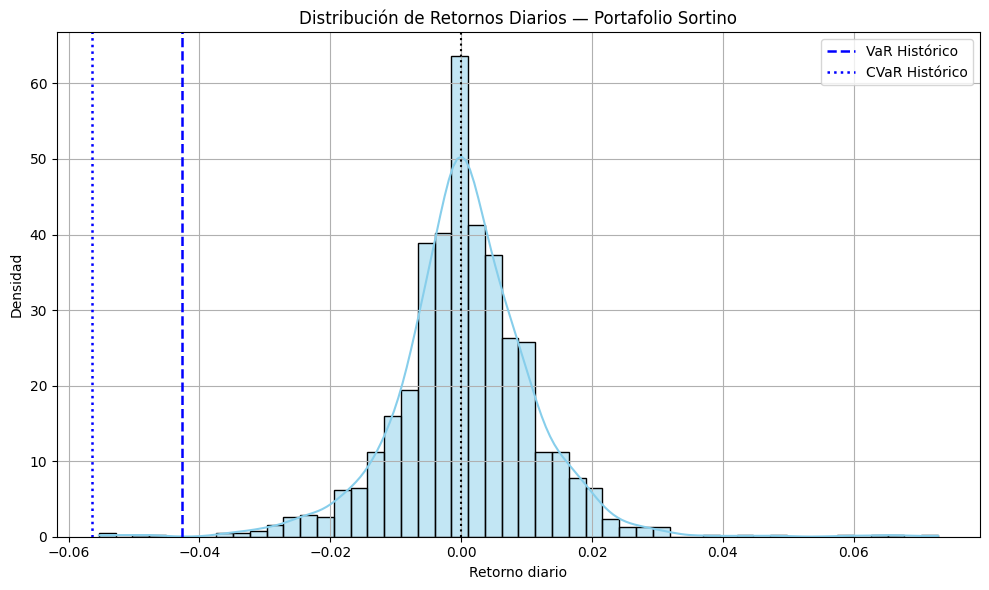

In [176]:
def graficar_distribucion_filtrada(nombre_port, pesos, retornos,
                                   df_reg_ok,
                                   dfs_var_port,         # dict método -> df_var_<método>_port_pct
                                   df_cvar_port_pct=None,# df_cvar_port_pct con filas 'CVaR <método>'
                                   dibujar_cvar=True):
    # Métodos aprobados para este portafolio
    met_aprob = df_reg_ok.loc[df_reg_ok['Portafolio'] == nombre_port, 'Método'].unique()
    if len(met_aprob) == 0:
        print(f"No hay métodos aprobados para el portafolio {nombre_port}.")
        return

    # Colores por método (consistentes con tu bloque original)
    colores_metodo = {
        'Delta-Normal': 'red',
        'Histórico': 'blue',
        'Monte Carlo': 'green',
        'EWMA': 'orange',
        'GARCH': 'purple',
    }

    # Retornos diarios observados del portafolio
    ret_port = retornos @ pesos

    # Plot distribución
    plt.figure(figsize=(10, 6))
    sns.histplot(ret_port, bins=50, kde=True, color='skyblue', stat='density')
    plt.title(f"Distribución de Retornos Diarios — Portafolio {nombre_port}")
    plt.xlabel("Retorno diario")
    plt.ylabel("Densidad")

    # Líneas de VaR (y CVaR) solo para métodos aprobados
    for metodo in met_aprob:
        # 1) VaR del portafolio para este método
        df_var_port = dfs_var_port.get(metodo, None)
        if df_var_port is not None and (nombre_port in df_var_port.columns):
            # Usa .iloc[0] para acceder al primer (y único) valor de VaR Portafolio %
            try:
                var_pct = float(df_var_port.loc['VaR Portafolio %', nombre_port])
                var_val = -var_pct / 100.0
                plt.axvline(var_val, color=colores_metodo.get(metodo, 'red'),
                            linestyle='--', linewidth=1.8, label=f"VaR {metodo}")
            except Exception:
                pass

        # 2) (Opcional) CVaR del portafolio para este método
        if dibujar_cvar and (df_cvar_port_pct is not None) and (nombre_port in df_cvar_port_pct.columns):
            fila_cvar = f'CVaR {metodo}'
            if fila_cvar in df_cvar_port_pct.index:
                try:
                    cvar_pct = float(df_cvar_port_pct.loc[fila_cvar, nombre_port])
                    cvar_val = -cvar_pct / 100.0
                    plt.axvline(cvar_val, color=colores_metodo.get(metodo, 'red'),
                                linestyle=':', linewidth=1.8, label=f"CVaR {metodo}")
                except Exception:
                    pass

    plt.axvline(0, color='black', linestyle=':')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Mapeo MÉTODO -> DF de VaR (portafolio %) que ya calculaste ---
dfs_var_port = {
    'Delta-Normal': df_var_portafolio_pct,   # índice: 'VaR Portafolio %'
    'Histórico':    df_var_hist_port_pct,
    'Monte Carlo':  df_var_mc_port_pct,
    'EWMA':         df_var_ewma_port_pct,
    'GARCH':        df_var_garch_port_pct,
}

# Dibujar SOLO para portafolios con al menos un método aprobado
# Asegúrate de que df_regulatorio_ok existe y no está vacío
if 'df_regulatorio_ok' not in globals() or df_regulatorio_ok.empty:
    print("No se puede generar la gráfica resumen. No hay modelos que pasen la validación regulatoria.")
else:
    ports_con_aprobados = df_regulatorio_ok['Portafolio'].unique()
    for nombre_port in ports_con_aprobados:
        pesos = portafolios[nombre_port]
        graficar_distribucion_filtrada(
            nombre_port=nombre_port,
            pesos=pesos,
            retornos=ret_activos,
            df_reg_ok=df_regulatorio_ok,
            dfs_var_port=dfs_var_port,
            df_cvar_port_pct=df_cvar_port_pct,  # si no quieres CVaR, pásalo como None o dibujar_cvar=False
            dibujar_cvar=True
        )

## 6. Backtesting

In [177]:
from scipy.stats import chi2

# ---- utilidades de backtest ----
def generar_violaciones(retornos_portafolio, var_series_pos):
    return (retornos_portafolio < -var_series_pos).astype(int)

def test_kupiec(violaciones, alpha):
    n = len(violaciones)
    x = int(violaciones.sum())
    if n == 0:
        return np.nan
    pi = x / n
    pi0 = 1 - alpha
    # manejar casos extremos para evitar log(0)
    if pi == 0 or pi == 1:
        return np.nan
    LR_pof = -2 * (np.log((1 - pi0)**(n - x) * pi0**x) -
                   np.log((1 - pi)**(n - x) * pi**x))
    return 1 - chi2.cdf(LR_pof, df=1)

def test_christoffersen(violaciones):
    v = np.asarray(violaciones, dtype=int)
    if len(v) < 2:
        return np.nan
    n00 = n01 = n10 = n11 = 0
    for t in range(1, len(v)):
        prev, curr = v[t - 1], v[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    # probabilidades de transición (con guardas)
    if (n00 + n01) == 0 or (n10 + n11) == 0 or (n00 + n01 + n10 + n11) == 0:
        return np.nan
    pi01 = n01 / (n00 + n01)
    pi11 = n11 / (n10 + n11)
    pi   = (n01 + n11) / (n00 + n01 + n10 + n11)
    # evitar log(0)
    eps = 1e-12
    logL_uncond = n00*np.log(max(1-pi,eps)) + (n01+n10+n11)*np.log(max(pi,eps))
    logL_cond   = (
        n00*np.log(max(1-pi01,eps)) + n01*np.log(max(pi01,eps)) +
        n10*np.log(max(1-pi11,eps)) + n11*np.log(max(pi11,eps))
    )
    LR_indep = -2 * (logL_uncond - logL_cond)
    return 1 - chi2.cdf(LR_indep, df=1)

# ---- funciones de VaR rolling por método (horizonte = 1 día para backtesting) ----
def var_rolling_historico(ret_activos, w, alpha, window=250):
    ret_port = ret_activos @ w
    vals = []
    for i in range(window, len(ret_port)):
        roll = ret_port.iloc[i-window:i]
        var_i = -np.percentile(roll, (1 - alpha) * 100)  # magnitud positiva
        vals.append(var_i)
    return ret_port.iloc[window:].values, np.array(vals)

def var_rolling_delta_normal(ret_activos, w, alpha, window=250):
    z = abs(norm.ppf(1 - alpha))
    ret_port = ret_activos @ w
    vals = []
    for i in range(window, len(ret_activos)):
        sub = ret_activos.iloc[i-window:i]
        cov = sub.cov().values
        port_vol = np.sqrt(np.dot(w, np.dot(cov, w)))
        var_i = z * port_vol  # magnitud positiva (1 día)
        vals.append(var_i)
    return ret_port.iloc[window:].values, np.array(vals)

def var_rolling_montecarlo(ret_activos, w, alpha, window=250, n_sim=20000):
    ret_port = ret_activos @ w
    vals = []

    for i in range(window, len(ret_activos)):
        sub = ret_activos.iloc[i-window:i]
        logrets = np.log1p(sub)

        mu   = logrets.mean().values
        sig  = logrets.std(ddof=1).values
        corr = np.corrcoef(logrets.T)

        # Guardas por estabilidad
        sig = np.where(sig <= 1e-8, 1e-8, sig)
        try:
            L = np.linalg.cholesky(corr)
        except np.linalg.LinAlgError:
            # pequeña regularización a la correlación si no es p.s.d.
            eps = 1e-6
            corr = (1 - eps) * corr + eps * np.eye(len(sig))
            L = np.linalg.cholesky(corr)

        # Simulaciones 1D
        Z = np.random.randn(n_sim, len(sig)) @ L.T
        logR = (mu - 0.5 * sig**2) * 1.0 + Z * sig * 1.0
        R = np.exp(logR) - 1.0
        port = R @ w

        var_i = -np.percentile(port, (1 - alpha) * 100.0)  # magnitud positiva
        vals.append(var_i)

    return ret_port.iloc[window:].values, np.array(vals)

def var_rolling_ewma(ret_activos, w, alpha, window=250, lam=lambda_):
    z = abs(norm.ppf(1 - alpha))
    ret_port = ret_activos @ w
    vals = []
    for i in range(window, len(ret_activos)):
        sub = ret_activos.iloc[i-window:i]
        # vol EWMA individual (último punto)
        vols = []
        for col in sub.columns:
            serie = sub[col].values
            var_t = np.var(serie[:5]) if len(serie)>=5 else np.var(serie)  # semilla
            for r in serie[1:]:
                var_t = lam*var_t + (1-lam)*(r**2)
            vols.append(np.sqrt(var_t))
        vols = np.array(vols)
        corr = np.corrcoef(sub.T)
        ewma_cov = np.outer(vols, vols) * corr
        port_vol = np.sqrt(np.dot(w, np.dot(ewma_cov, w)))
        vals.append(z * port_vol)
    return ret_port.iloc[window:].values, np.array(vals)

def var_rolling_garch(ret_activos, w, alpha, window=750):
    from arch import arch_model
    import warnings
    z = abs(norm.ppf(1 - alpha))
    ret_port = ret_activos @ w
    vals = []
    for i in range(window, len(ret_activos)):
        sub = ret_activos.iloc[i-window:i]
        sigmas = []
        for col in sub.columns:
            serie = (sub[col].values * 100.0)  # en %
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=UserWarning)
                    am = arch_model(serie, vol='GARCH', p=1, q=1, rescale=False)
                    res = am.fit(disp='off', show_warning=False)
                # pronóstico 1-step ahead de la varianza (en %^2)
                fcast = res.forecast(horizon=1, reindex=False)
                var_next = float(fcast.variance.values[-1, 0])      # %^2
                sigma_next = np.sqrt(var_next) / 100.0              # a proporción
                # sanity fallback
                if not np.isfinite(sigma_next) or sigma_next <= 0:
                    raise ValueError("sigma_next inválida")
            except Exception:
                sigma_next = float(np.std(serie, ddof=1) / 100.0)   # fallback: vol histórica
            sigmas.append(sigma_next)
        sigmas = np.array(sigmas)
        corr = np.corrcoef(sub.T)
        cov_garch = np.outer(sigmas, sigmas) * corr
        port_vol = np.sqrt(np.dot(w, np.dot(cov_garch, w)))
        vals.append(z * port_vol)
    return ret_port.iloc[window:].values, np.array(vals)

# Mapeo de método -> función rolling
rolling_funcs = {
    'Histórico':    var_rolling_historico,
    'Delta-Normal': var_rolling_delta_normal,
    'Monte Carlo':  var_rolling_montecarlo,
    'EWMA':         var_rolling_ewma,
    'GARCH':        var_rolling_garch,
}

# -------------------------------
# Ejecutar SOLO para df_regulatorio_ok
# -------------------------------
window_hist = 250     # ~1 año
window_dn   = 250
window_mc   = 250
window_ewma = 250
window_gch  = 250     # GARCH requiere más datos

ventanas = {
    'Histórico':    window_hist,
    'Delta-Normal': window_dn,
    'Monte Carlo':  window_mc,
    'EWMA':         window_ewma,
    'GARCH':        window_gch,
}

alpha_bt = confianza  # usar el mismo nivel que definiste

resultados_bt = []
errores_bt = []

# Asegura que tenemos df_regulatorio_ok construido (de tu validación)
if 'df_regulatorio_ok' not in globals():
    raise RuntimeError("df_regulatorio_ok no existe. Ejecuta primero la validación regulatoria.")

for _, fila in df_regulatorio_ok.iterrows():
    nombre_port = fila['Portafolio']
    metodo      = fila['Método']
    w           = portafolios[nombre_port]
    fun_roll    = rolling_funcs.get(metodo, None)
    if fun_roll is None:
        continue

    try:
        win = ventanas[metodo]
        # serie de retornos observados y serie de VaR pronosticado (magnitud positiva)
        ret_eval, var_series_pos = fun_roll(ret_activos, w, alpha_bt, window=win)
        # violaciones
        viol = generar_violaciones(ret_eval, var_series_pos)
        # tests
        p_k = test_kupiec(viol, alpha_bt)
        p_c = test_christoffersen(viol)

        resultados_bt.append({
            'Portafolio': nombre_port,
            'Método': metodo,
            'Observaciones': len(viol),
            'Violaciones': int(viol.sum()),
            'Tasa Observada': float(viol.mean()),
            'p-valor Kupiec': p_k,
            'p-valor Christoffersen': p_c
        })
    except Exception as e:
        errores_bt.append((nombre_port, metodo, str(e)))
        continue

df_backtest_ok = pd.DataFrame(resultados_bt).sort_values(['Portafolio','Método']).reset_index(drop=True)

print("Backtesting (solo modelos que pasaron regulación)")
display(df_backtest_ok)

if errores_bt:
    print("Modelos con error durante el backtesting:")
    for (p,m,err) in errores_bt:
        print(f" - {p} / {m}: {err}")

Backtesting (solo modelos que pasaron regulación)


,Portafolio,Método,Observaciones,Violaciones,Tasa Observada,p-valor Kupiec,p-valor Christoffersen
0,Sortino,Histórico,1215,70,0.057613,0.234018,0.0


## 7. Stress Testing

In [178]:
# Unir resultados de Kupiec y validación regulatoria
# Asegúrate de que df_backtest_ok existe y no está vacío
if 'df_backtest_ok' not in globals() or df_backtest_ok.empty:
    print("No se puede realizar Stress Testing. No hay modelos que pasen la validación regulatoria o el backtesting falló.")
else:
    df_kupiec_validado = df_backtest_ok.merge(
        df_regulatorio_ok[['Portafolio', 'Método']],
        on=['Portafolio', 'Método'],
        how='inner'
    )

    # Seleccionar el modelo con mayor p-valor
    if df_kupiec_validado.empty:
        raise ValueError("No hay modelos que pasen la validación regulatoria para stress testing.")

    mejor_modelo = df_kupiec_validado.sort_values('p-valor Kupiec', ascending=False).iloc[0]
    port_sel = mejor_modelo['Portafolio']
    metodo_sel = mejor_modelo['Método']

    print(f"Modelo seleccionado para Stress Testing: {port_sel} - {metodo_sel}")

    # Obtener el VaR del modelo seleccionado
    var_seleccionado_pct = resumen_pct.loc[f"VaR {metodo_sel}", port_sel]

    # Escenarios reales de stress testing
    escenarios = [
        {'nombre': 'COVID-19 Marzo 2020',   'ini': '2020-03-01', 'fin': '2020-03-31'},
        {'nombre': 'Invasión Ucrania 2022', 'ini': '2022-02-20', 'fin': '2022-03-10'},
        {'nombre': 'Caída Tech 2022',       'ini': '2022-12-01', 'fin': '2023-01-15'}
    ]

    # Calcular pérdidas y comparar con VaR
    resultados_stress = []
    # Asegúrate de usar ret_activos para el portafolio seleccionado
    ret_port_sel = ret_activos @ portafolios[port_sel]

    for esc in escenarios:
        fecha_ini, fecha_fin = esc['ini'], esc['fin']
        # Filtrar por rango de fechas
        ret_periodo = ret_port_sel.loc[fecha_ini:fecha_fin]

        if len(ret_periodo) == 0:
            print(f"No hay datos para {esc['nombre']} ({fecha_ini} a {fecha_fin}) en la serie.")
            continue

        # Calcular el retorno acumulado en el período
        perdida_pct = (ret_periodo + 1).prod() - 1
        perdida_pct *= 100  # a porcentaje
        perdida_usd = (perdida_pct / 100) * monto_invertido # a USD

        # Comparar con VaR (VaR es pérdida esperada, por eso usamos abs o lo comparamos con el negativo de la pérdida)
        # El VaR seleccionado ya está en magnitud positiva (%)
        supera_var = perdida_pct < -var_seleccionado_pct
        exceso_pp = abs(perdida_pct) - var_seleccionado_pct if supera_var else 0
        exceso_veces = (abs(perdida_pct) / var_seleccionado_pct) if supera_var and var_seleccionado_pct != 0 else 0 # Evitar división por cero

        resultados_stress.append({
            'Escenario': esc['nombre'],
            'Fecha Inicio': fecha_ini,
            'Fecha Fin': fecha_fin,
            'Pérdida %': perdida_pct,
            'Pérdida USD': perdida_usd,
            'VaR % (10D)': var_seleccionado_pct,
            'Supera VaR?': supera_var,
            'Exceso P.P.': exceso_pp,
            'Exceso Veces': exceso_veces
        })

    # Mostrar tabla final
    if resultados_stress:
        df_stress = pd.DataFrame(resultados_stress)
        print("Resultados de Stress Testing con eventos reales y comparación con VaR")
        display(df_stress.round(3))
    else:
        print("No se pudieron calcular resultados de Stress Testing para los escenarios definidos.")

Modelo seleccionado para Stress Testing: Sortino - Histórico
Resultados de Stress Testing con eventos reales y comparación con VaR


,Escenario,Fecha Inicio,Fecha Fin,Pérdida %,Pérdida USD,VaR % (10D),Supera VaR?,Exceso P.P.,Exceso Veces
0,COVID-19 Marzo 2020,2020-03-01,2020-03-31,-1.929,-1928.769,4.263,False,0,0
1,Invasión Ucrania 2022,2022-02-20,2022-03-10,-4.058,-4058.259,4.263,False,0,0
2,Caída Tech 2022,2022-12-01,2023-01-15,1.980,1980.301,4.263,False,0,0
